# Step 15: Interpreting Random Forest on structured data

In order to better understand where the predictions come from, we want to do the following things:
1. Examine feature and label relationships using rank correlation.
2. Train random forest with comparable performance
3. Calculate feature importance
4. Create partial dependence plots
5. Use lime package to explain single predicitons

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from tep.utils import load_array
feats = load_array('data/auxiliary_features.bc')
feats.shape

(1293005, 15)

In [3]:
import numpy as np

In [4]:
labels = load_array('data/regression_labels.bc')
labels = np.log1p(labels)
labels.shape

(1293005,)

In [5]:
data = np.column_stack(tup=(feats, labels))
data.shape

(1293005, 16)

In [6]:
from tep.modelUtils import load_architecture
model = load_architecture('models/dffn_reg_5h_64n.json')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_inputs (BatchNorm (None, 15)                60        
_________________________________________________________________
fc_1 (Dense)                 (None, 64)                1024      
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 64)                256       
_________________________________________________________________
fc_2 (Dense)                 (None, 64)                4160      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 64)                256       
_________________________________________________________________
fc_3 (Dense)                 (None, 64)                4160      
_________________________________________________________________
bn_3 (BatchNormalization)    (None, 64)                256       
__________

In [7]:
model.load_weights('models/dffn_reg_5h_64n.hdf5')

In [8]:
preds = model.predict(feats[-10000:])
acts = labels[-10000:]

In [9]:
from tep.trainUtils import r2
from keras.optimizers import Adam
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=[r2])

In [10]:
model.evaluate(x=feats[-10000:], y=labels[-10000:])

10000/10000 [==============================] - 1s 122us/step


[1.0348384994506836, 0.74490957508087163]

In [11]:
import pandas as pd
columns = ['urls', 'hashtags', 'mentions', 'length', 'followers', 'friends', 'verified', 'listings', 'tweets', 'tweet_freq', 'favorites', 'favorite_freq', 'account_age', 'hour', 'quote', 'retweets']
df = pd.DataFrame(data=data, columns=columns)

In [12]:
df.head()

urls  hashtags  mentions  length  followers  friends  verified  listings  \
0   0.0       0.0       0.0    78.0  1282170.0   4029.0       1.0    3132.0   
1   1.0       0.0       0.0   139.0     2567.0   2931.0       0.0      46.0   
2   1.0       2.0       0.0    89.0    14580.0   2447.0       1.0     380.0   
3   1.0       0.0       0.0   123.0   415819.0     50.0       1.0    2382.0   
4   1.0       0.0       2.0   135.0    21285.0   2568.0       1.0     435.0   

    tweets  tweet_freq  favorites  favorite_freq  account_age  hour  quote  \
0  13623.0    4.049643     4134.0       1.228894       3364.0  20.0    0.0   
1   2318.0    1.115496      201.0       0.096728       2078.0  16.0    0.0   
2   7333.0    2.220775     1385.0       0.419443       3302.0  14.0    0.0   
3   5775.0    2.970679      250.0       0.128601       1944.0  19.0    0.0   
4  12513.0    4.457784     9239.0       3.291414       2807.0  19.0    0.0   

   retweets  
0  4.795791  
1  0.000000  
2  1.386294  
3  1.791759  
4  0.000000

## Feature and label rank correlation

We calculate rank correlation because we don't necessarily expect linear relationships in our data. Also, rank correlation is a nonparametric measure, i.e., we do not assume that the dataset is normally distributed.

In [13]:
from scipy.stats import spearmanr

In [14]:
corr = np.round(spearmanr(df).correlation, 4)

In [15]:
corr.shape

(16, 16)

In [16]:
import matplotlib.pyplot as plt

def plot_corr(corr, columns):
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(columns),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(columns)
    ax.set_yticklabels(columns)
    plt.show()
    return

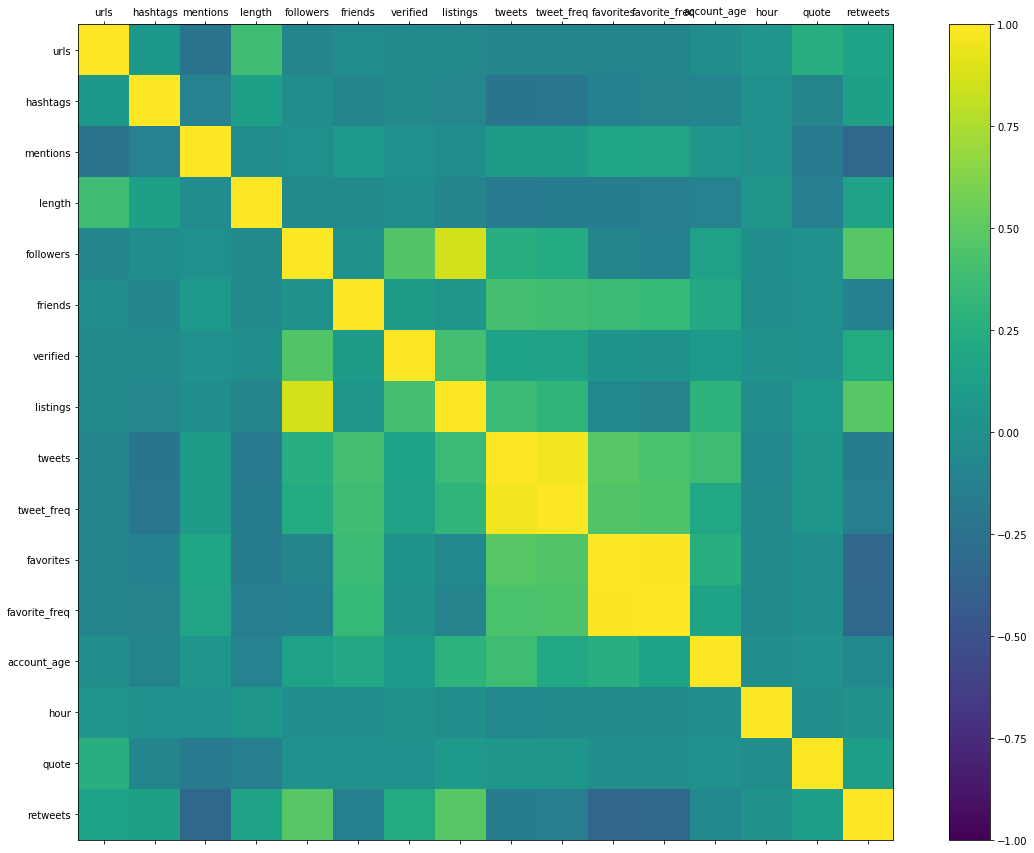

In [17]:
plot_corr(corr, columns)

Unsurprisingly, this suggests that the number of followers and listings are the strongest indicators of a tweet's engagement. We can also see that content features alone are not useful for predicting retweets, as correlation is weak here.

## Train comparable random forest

In [18]:
X_train = feats[:-10000]
y_train = labels[:-10000]
X_valid = feats[-10000:]
y_valid = labels[-10000:]
print(X_train.shape)
print(y_valid.shape)

(1283005, 15)
(10000,)


In [19]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=8, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.810718343354311, 0.9088102596416965, 0.85639152519973971, 0.82121488242368801, 0.81414482917714603]


## Analyze feature importance

In [22]:
from fastai.structured import rf_feat_importance

In [28]:
df_trn = df.drop('retweets', axis=1)
df_trn.shape

(1293005, 15)

In [29]:
fi = rf_feat_importance(m, df_trn)
fi

cols       imp
4       followers  0.548185
2        mentions  0.120230
8          tweets  0.054658
10      favorites  0.040744
7        listings  0.038516
12    account_age  0.037772
3          length  0.037611
5         friends  0.030400
11  favorite_freq  0.021488
13           hour  0.021229
9      tweet_freq  0.018499
0            urls  0.015414
1        hashtags  0.011703
14          quote  0.003188
6        verified  0.000361

In [31]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(20,12), legend=False)

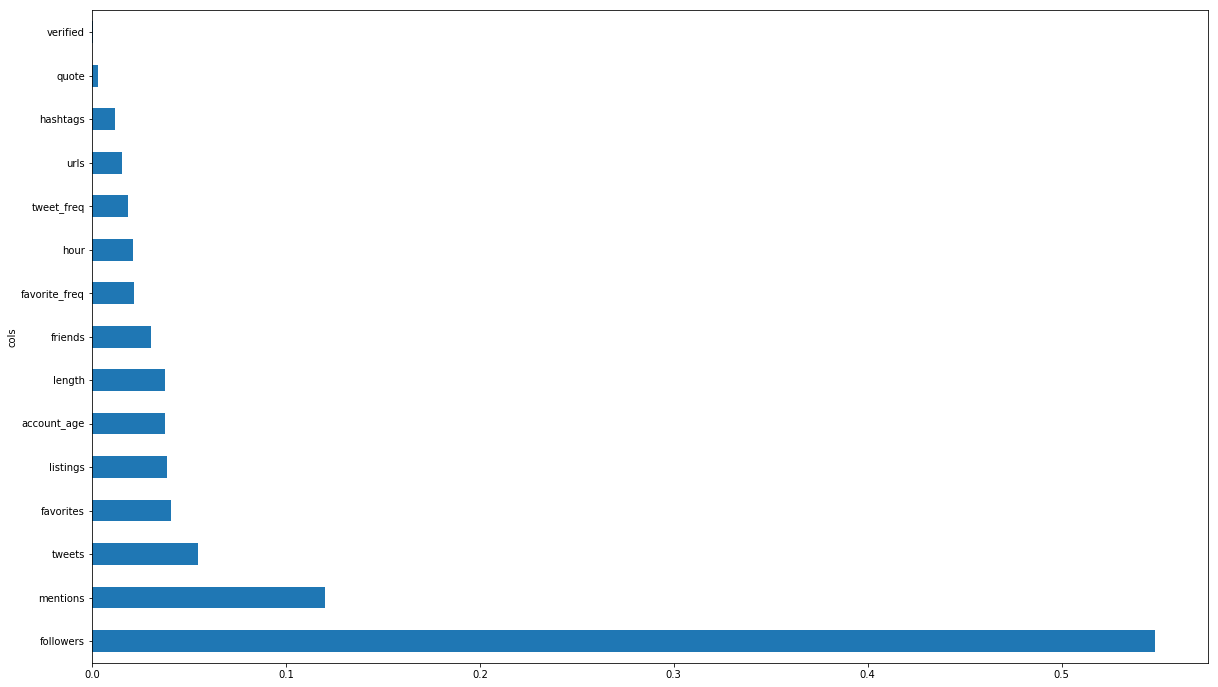

In [32]:
plot_fi(fi)

We can see that the number of followers and mentions are the strongest indicators for tweet engagement.
Let's see if the importance values change if single trees in the forest are limited to a subset of features.

In [33]:
m1 = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_features=0.6, min_samples_leaf=8, oob_score=True)
m1.fit(X_train, y_train)
print_score(m1)

[0.8243228763852881, 0.8981457233208836, 0.85153134450524737, 0.82538621169610227, 0.81726620701899333]


In [36]:
fi1 = rf_feat_importance(m1, df_trn)
fi1

cols       imp
4       followers  0.424962
7        listings  0.153207
2        mentions  0.096412
8          tweets  0.053244
10      favorites  0.049518
12    account_age  0.042808
11  favorite_freq  0.035456
3          length  0.034924
9      tweet_freq  0.030588
5         friends  0.028910
13           hour  0.018379
0            urls  0.015383
1        hashtags  0.010737
14          quote  0.003096
6        verified  0.002376

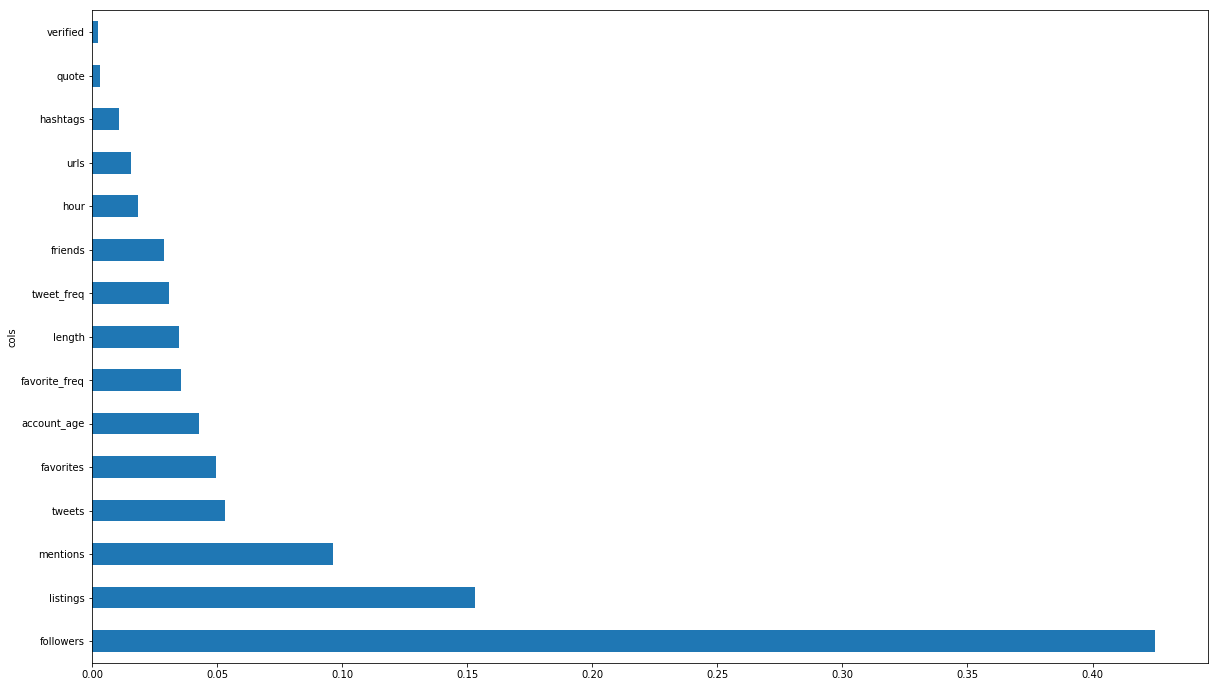

In [37]:
plot_fi(fi1)

We can observe that follower importance decreases as the feature cannot be used for every single tree. In turn, listings become more important to the model. This makes sense, since the number of listings influences the size of the author's audience.

As a final step, we can now leave out the least important features and create a new model.

In [38]:
to_keep = fi1[fi1.imp>0.02].cols; len(to_keep)

10

In [39]:
df_keep = df_trn[to_keep].copy()

In [42]:
def split_vals(a,n_val): return a[:-n_val], a[-n_val:]

In [46]:
X_train, X_valid = split_vals(df_keep, 10000); X_trn.shape

(1283005, 10)

First, train the model without limiting the set of features for each tree.

In [47]:
m2 = RandomForestRegressor(n_estimators=40, min_samples_leaf=8, n_jobs=-1, oob_score=True)
m2.fit(X_trn, y_train)
print_score(m2)

[0.9149869799753673, 0.9659921880310189, 0.81707633287902626, 0.7980089388860282, 0.79249803427948062]


Then, use only half of the features for each tree.

In [48]:
m3 = RandomForestRegressor(n_estimators=40, min_samples_leaf=8, max_features=0.5, n_jobs=-1, oob_score=True)
m3.fit(X_train, y_train)
print_score(m3)

[0.9179408556582779, 0.9652698076150598, 0.81589335220149761, 0.79831092855074859, 0.79306540308260276]


Both models perform worse than our previous RF. We should thus keep all features. This makes sense, since the number of features is already relatively small.

Let's dive deeper into analyzing our best-performing model.

In [49]:
X_train, X_valid = split_vals(df_trn, 10000); X_train.shape

(1283005, 15)

In [50]:
m = m1
fi = fi1
print_score(m)

[0.8243228763852881, 0.8981457233208836, 0.85153134450524737, 0.82538621169610227, 0.81726620701899333]


## Partial dependence plots

Next, we want to examine univariate relationships between single features and the target variable. For this, we will use partial dependence plots. These take care of possible collinearities, i.e., external effects, in our data set.
Partial dependence examines these relationships while assuming that all other variables are equal. This mean, all variance comes from the examined variable.

In [53]:
from pdpbox import pdp
from plotnine import *
from fastai.structured import get_sample

In [77]:
df_pdp = df_trn.copy()
df_pdp.shape

(1293005, 15)

In [78]:
df_pdp['followers'] = np.log1p(df_pdp['followers'])
df_pdp['friends'] = np.log1p(df_pdp['friends'])
df_pdp['listings'] = np.log1p(df_pdp['listings'])
df_pdp['tweets'] = np.log1p(df_pdp['tweets'])
df_pdp['favorites'] = np.log1p(df_pdp['favorites'])
df_pdp['account_age'] = np.divide(df_pdp['account_age'], 365)

In [79]:
X_train, X_valid = split_vals(df_pdp, 10000); X_train.shape

(1283005, 15)

In [80]:
m_pdp = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_features=0.6, min_samples_leaf=8, oob_score=True)
m_pdp.fit(X_train, y_train)
print_score(m_pdp)

[0.8252934078590326, 0.9015490297468081, 0.85118153417557973, 0.82406039090164884, 0.81695286157006242]


In [87]:
sample = get_sample(X_train, 1000)

In [109]:
def plot_pdp(m, x, feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, cluster=clusters is not None, n_cluster_centers=clusters)

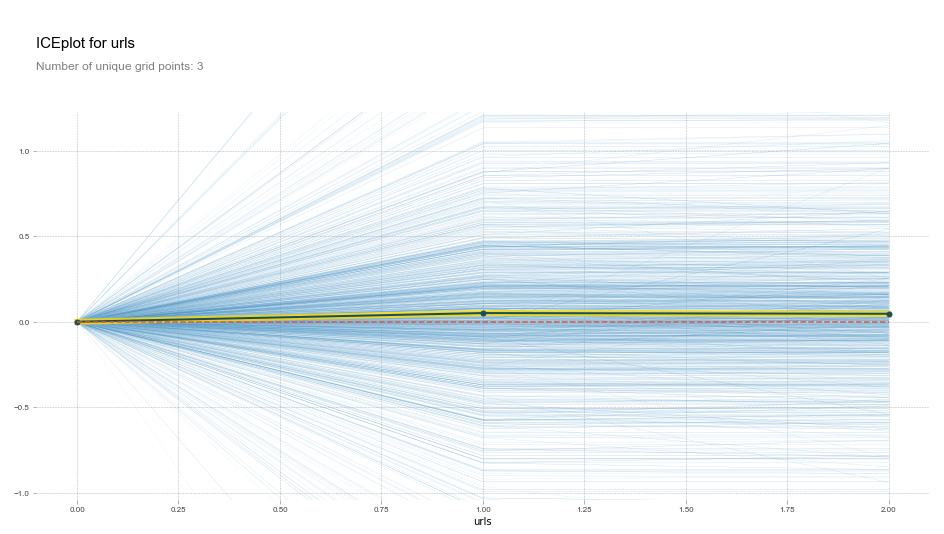

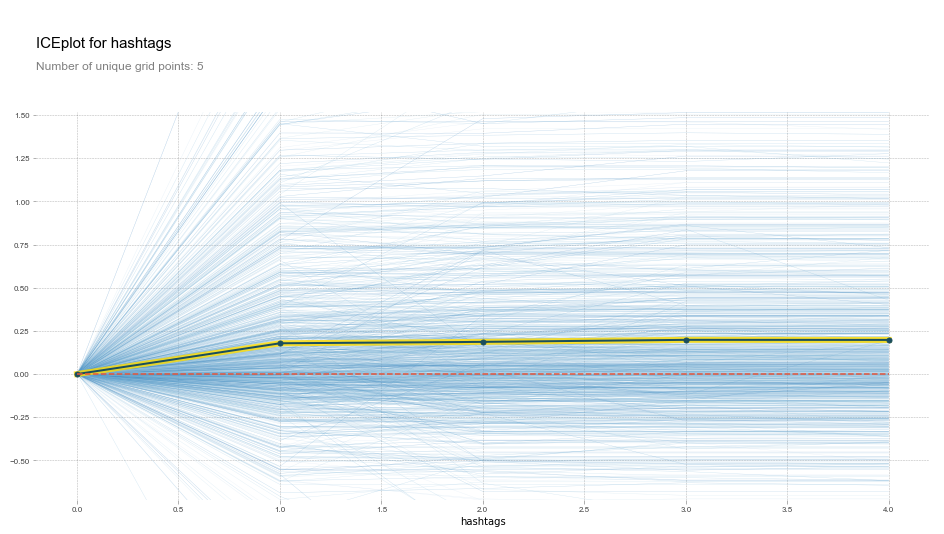

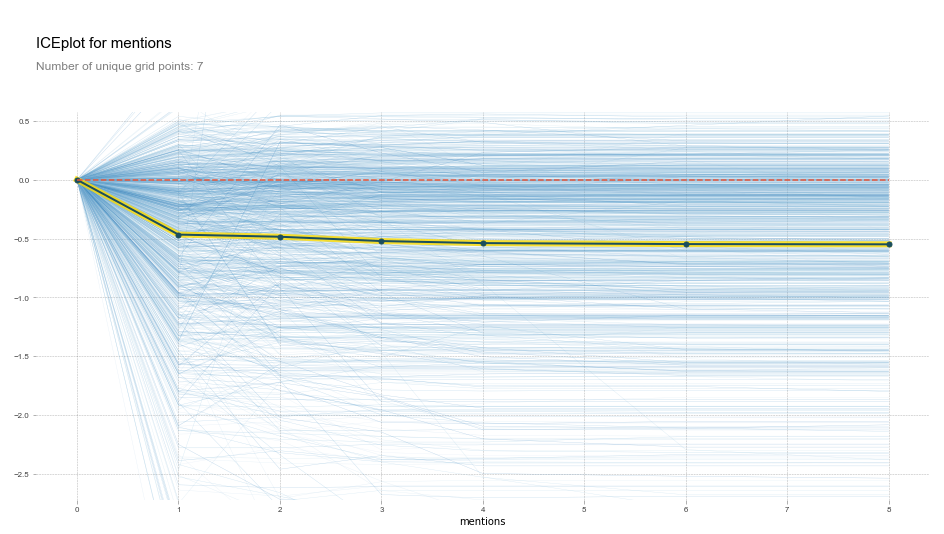

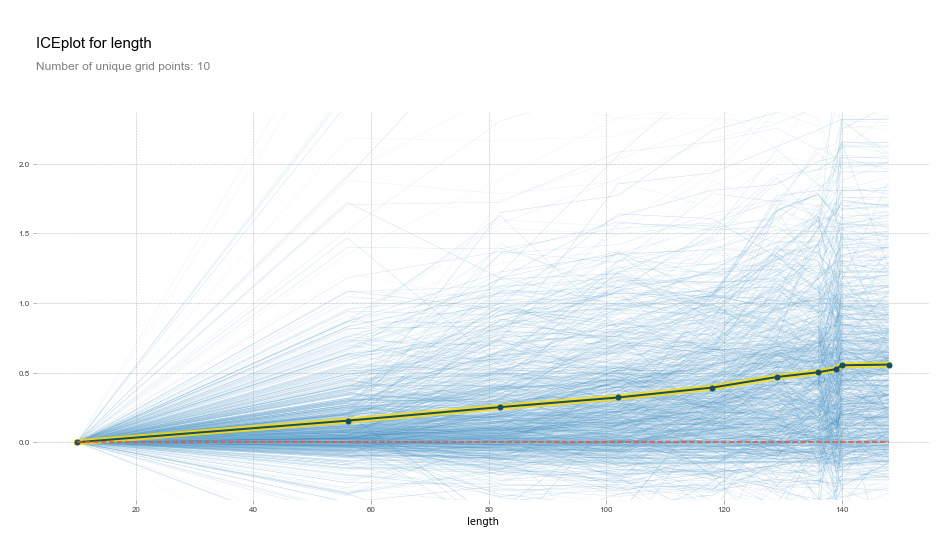

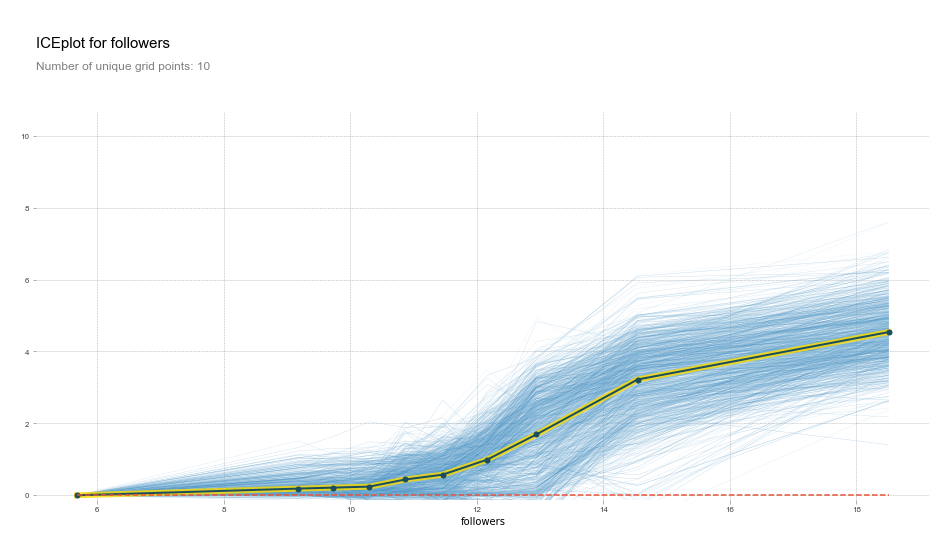

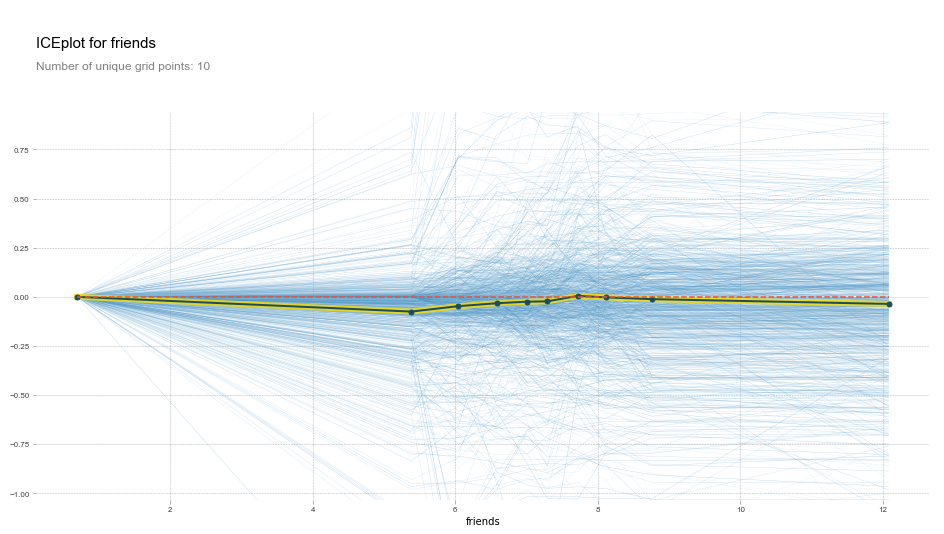

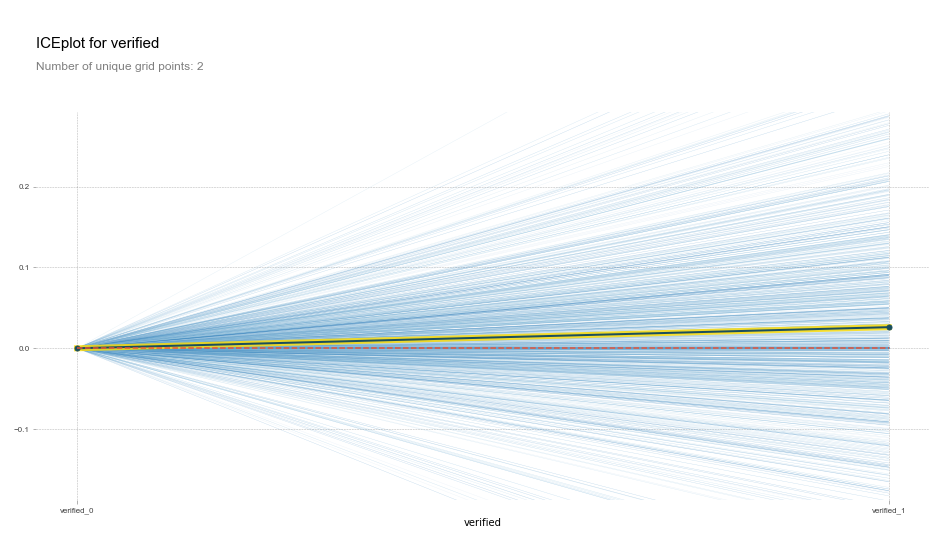

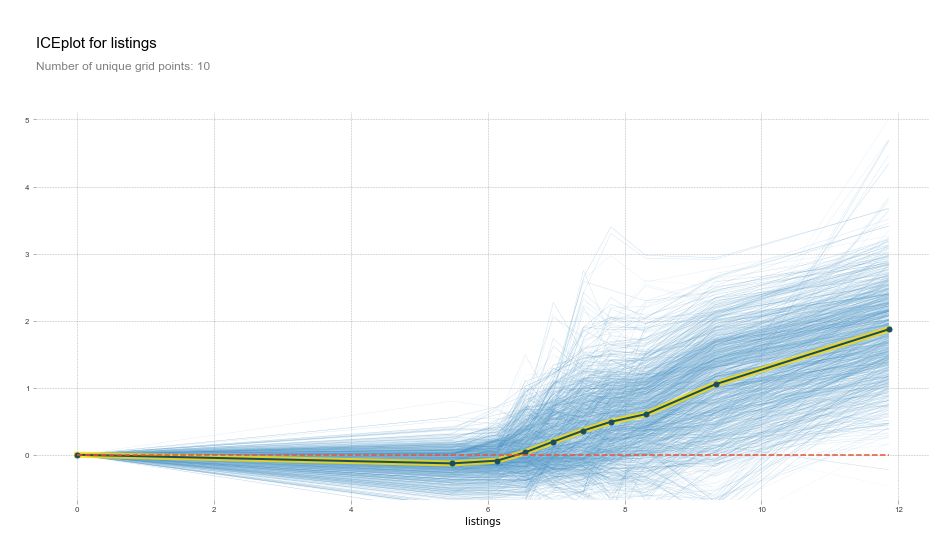

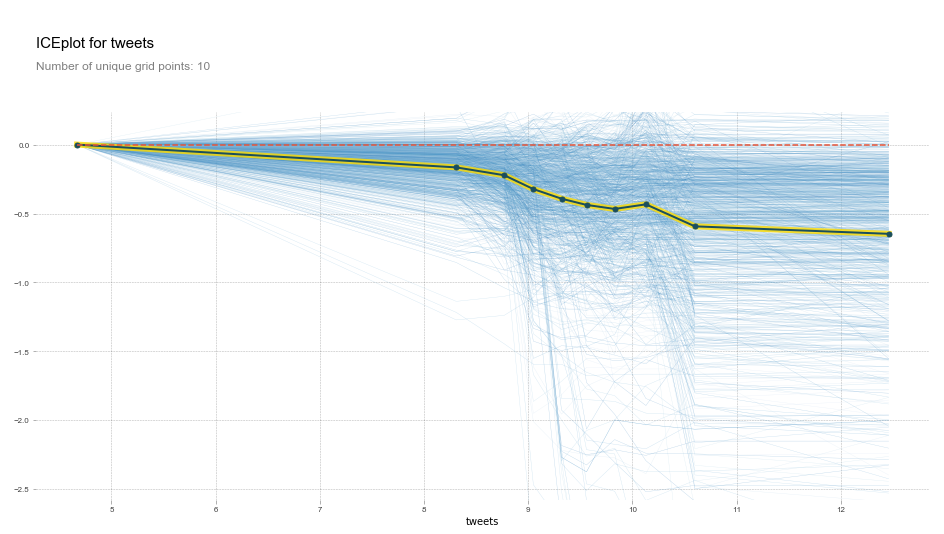

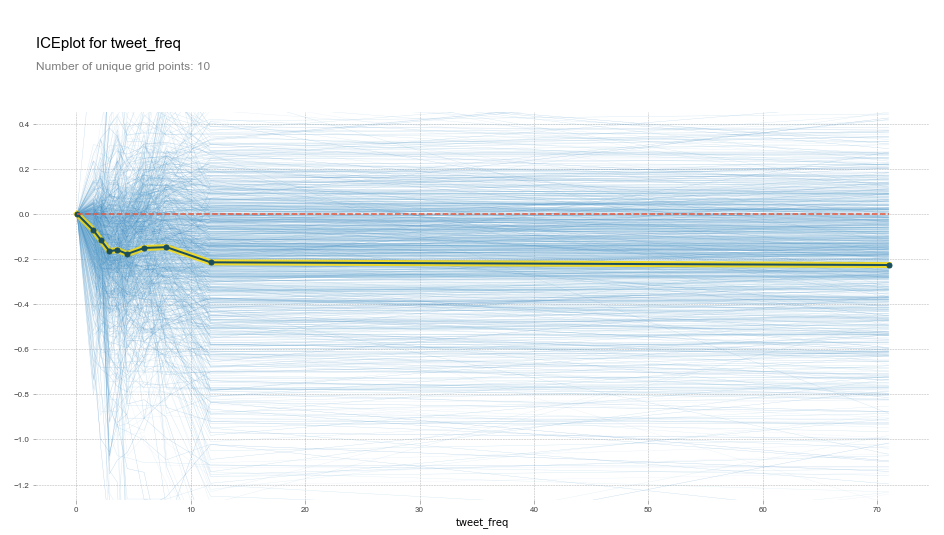

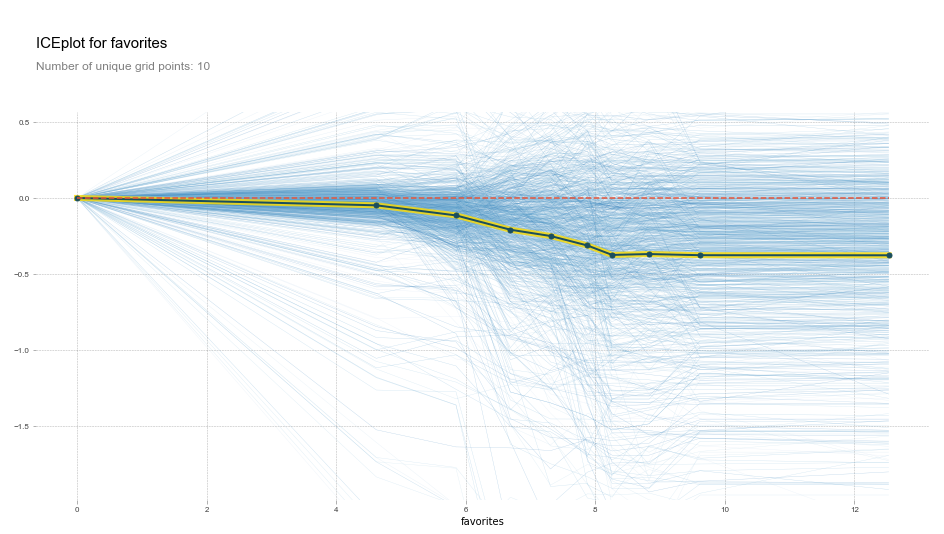

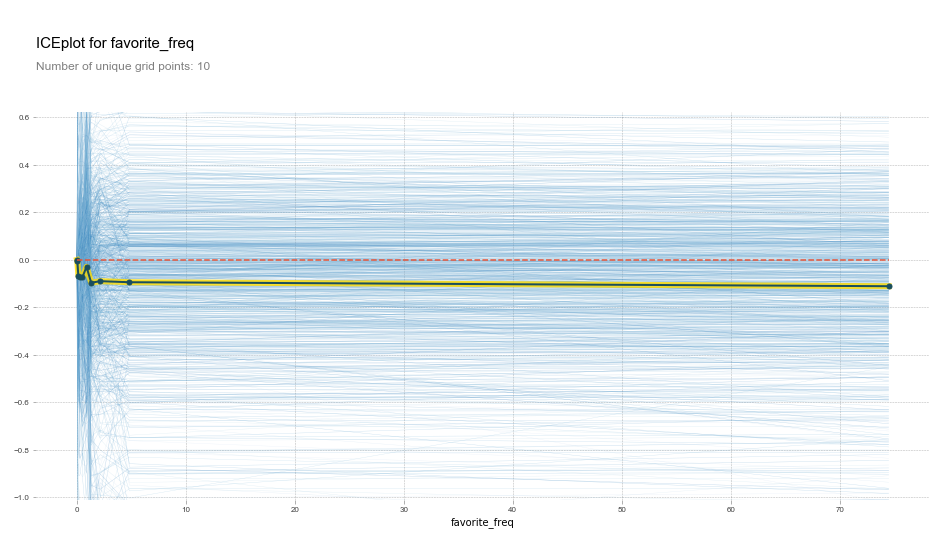

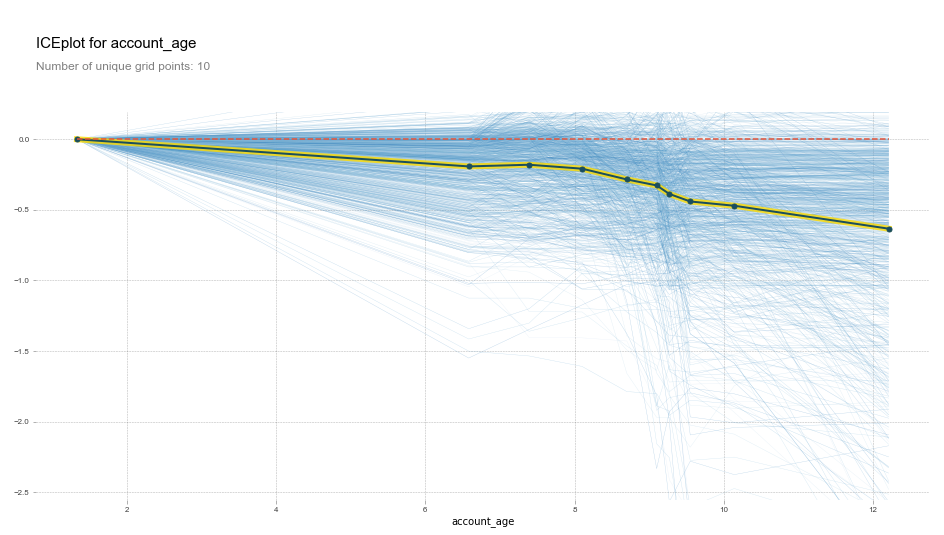

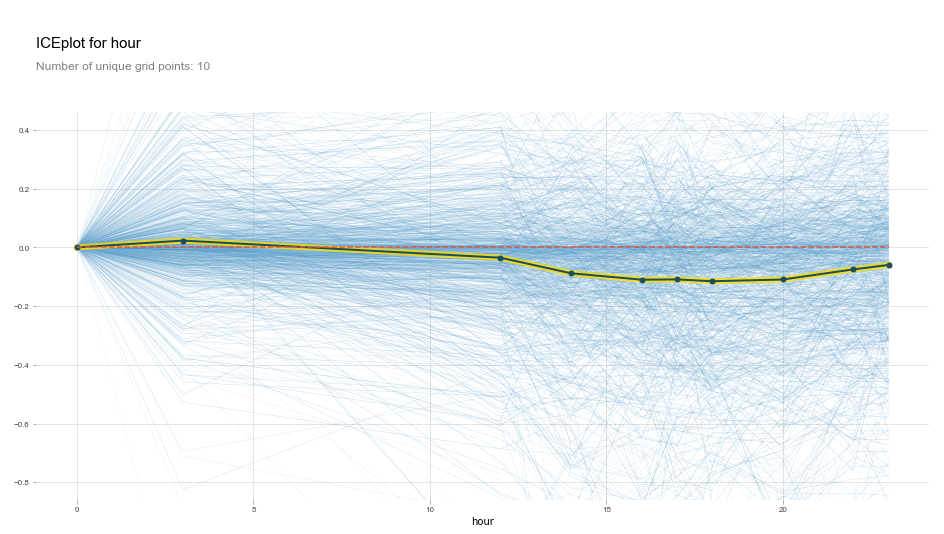

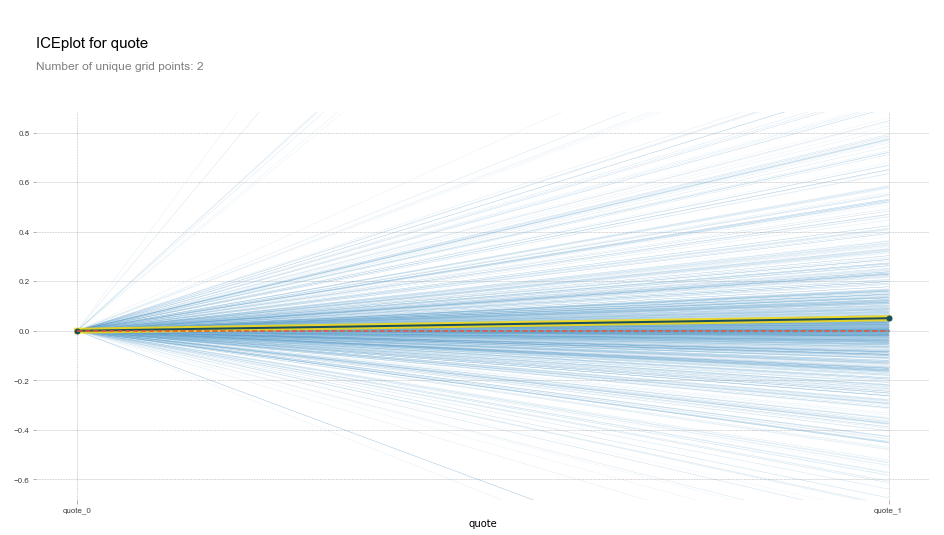

In [102]:
for col in sample.columns:
    plot_pdp(m_pdp, sample, col)

In [92]:
fi_pdp = rf_feat_importance(df=df_pdp, m=m_pdp); fi_pdp

cols       imp
4       followers  0.417292
7        listings  0.157233
2        mentions  0.100692
10      favorites  0.052001
8          tweets  0.047953
12    account_age  0.042461
11  favorite_freq  0.035785
3          length  0.035367
9      tweet_freq  0.034140
5         friends  0.027002
13           hour  0.018379
0            urls  0.015042
1        hashtags  0.010517
14          quote  0.003302
6        verified  0.002834

## Draw sample trees

We can look at a sample tree if we limit tree depth.

In [112]:
X_train, X_valid = split_vals(df_trn, 10000); X_train.shape

(1283005, 15)

In [115]:
m_drw = RandomForestRegressor(n_estimators=1, max_depth=3, n_jobs=-1, oob_score=True)
m_drw.fit(X_train, y_train)
print_score(m_drw)

[1.4789581340094908, 1.4699803395912012, 0.5220837128389948, 0.53225626997964914, -0.26816803138200385]


In [116]:
from fastai.structured import draw_tree

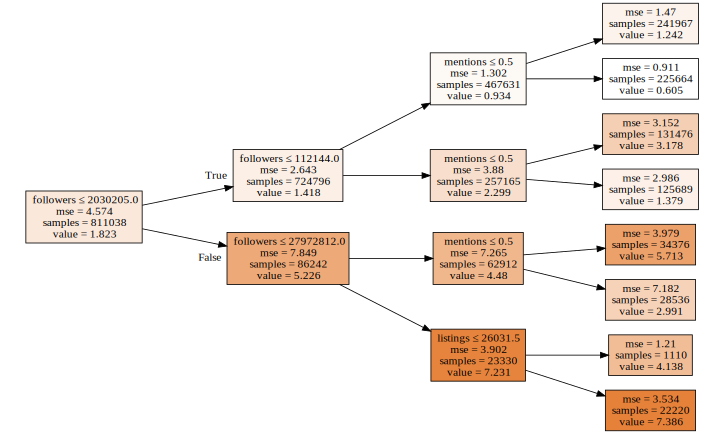

In [117]:
draw_tree(m_drw.estimators_[0], df_trn, precision=3)

This again shows the importance of the followers, mentions and listings features.